# **CSE641: *Deep Learning Assignment-1***

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset, random_split

In [2]:
!pip install idx2numpy

In [18]:
import os
import gzip
import time
import random
import idx2numpy
import numpy as np
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
from typing import Callable, Any, Iterator

## **Question: 1**

For Question-1, we implement the `pytorch.utils.data.Dataset` and `pytorch.utils.data.DataLoader` classes from scratch in Python. Specifically, we make use of the `MNIST` dataset, hence the `torchvision.datasets.MNIST`. Using the template provided, we implement the classes `MNISTDataset` and `CustomDataLoader`. Finally, the performance of the scratch implementation is compared with the `torch` implementations by plotting a graph of batch-size vs total data loading time.

### **Solutions & Results**

The implementation of `MNIStDataset` and `CustomDataLoader` is given in the following cells. A custom version of the `torchvision.transforms.ToTensor` is also implemented in the class `ToTensor` just for the vibes and making the comparison more fun. The time taken to load one batch of data is measured for both the PyTorch and the Scratch implementations by averaging over 10 runs for different batch sizes, specifically, $[2^{5}, 2^{6}, ..., 2^{12}]$, i.e. $[32, 64, ..., 4096]$.

Surprisingly, the scratch implementation of `CustomDataLoader` is faster than the `torch` implementation of `DataLoader` for small batch sizes. However, as the batch size increases, the `torch` implementation becomes faster than the scratch implementation. This is probably because the `torch` implementation performs optimizations that are more efficient for larger batch sizes.

### **References**

1. [`torch.utils.data.DataLoader`, `torch.utils.data.Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
2. [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html#MNIST)

In [4]:
class MNISTDataset:
    """
    Represents the MNIST dataset. If the dataset is not found in the root directory,
    it will be downloaded automatically from the internet. By default, the the training
    set is loaded.
    :params:
        root: the root directory where the dataset will be stored
        train: if True, the training set will be loaded, otherwise the test set will be loaded
        transform: a callable that takes in an image and applies a transformation to it
        target_transform: a callable that takes in a target and applies a transformation to it
        download: if True, the dataset will be downloaded from the internet and stored in the root directory
    :attrs:
        data: the images in the dataset
        targets: the labels in the dataset
    """

    URLs: tuple[str] = (
        r"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        r"http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
        r"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        r"http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
    )

    def __init__(self, root: str, train: bool|None = True, transform: Callable|None = None, target_transform: Callable|None = None, download: bool|None = False):
        """
        Initializes the MNIST Dataset.
        """
        self.root = os.path.join(os.getcwd(), os.path.join(root, "MNIST"))
        self.train = train
        if download and not os.path.exists(self.root):
            self._download()
        self.transform = transform
        self.target_transform = target_transform
        self._load()

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, index: int) -> tuple[Any, Any]:
        """
        Returns the image and target at the given index after applying their respective
        transformations (if specified).
        """
        image, target = Image.fromarray(self.data[index]), int(self.targets[index])
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target

    def _download(self) -> None:
        """
        Downloads the dataset from the internet and stores it in the root directory.
        """
        directory = os.path.join(self.root, "raw")
        os.makedirs(directory, exist_ok=True)
        for url in MNISTDataset.URLs:
            filename = os.path.join(directory, os.path.basename(url))
            destination = filename.replace(".gz", "")
            if os.path.exists(destination):
                continue
            urllib.request.urlretrieve(url, filename)
            with gzip.open(filename, "rb") as f_in, open(destination, "wb") as f_out:
                f_out.write(f_in.read())

    def _load(self) -> None:
        """
        Loads the specified dataset from the root directory.
        """
        prefix = "train" if self.train else "t10k"
        images_filename = os.path.join(self.root, "raw", f"{prefix}-images-idx3-ubyte")
        labels_filename = os.path.join(self.root, "raw", f"{prefix}-labels-idx1-ubyte")
        self.data = idx2numpy.convert_from_file(images_filename)
        self.targets = torch.tensor(idx2numpy.convert_from_file(labels_filename), dtype=torch.int64)


class CustomDataLoader:
    """
    Represents a Custom DataLoader (similar to the one in PyTorch) that can be used to iterate
    over a dataset in batches. The DataLoader can be used to iterate over the dataset multiple times
    and can be shuffled if needed.
    :params:
        dataset: the dataset to be loaded
        batch_size: the number of samples in each batch
        shuffle: if True, the dataset will be shuffled before each iteration
    :attrs:
        dataset_size: the number of samples in the dataset
        indices: the ordered indices of the samples in the dataset
    """

    def __init__(self, dataset: MNISTDataset|Dataset, batch_size: int|None = 1, shuffle: bool|None = False):
        """
        Initializes the DataLoader. See help(CustomDataLoader) for more information.
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset_size = len(dataset)
        self.indices = torch.arange(self.dataset_size)

    def __len__(self) -> int:
        """
        Returns the number of batches in the dataset.
        """
        return (self.dataset_size + self.batch_size - 1) // self.batch_size

    def __iter__(self) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        """
        Returns an iterator over the dataset.
        """
        if self.shuffle:
            random.shuffle(self.indices)
        self.current_index = 0
        return self

    def __next__(self) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the next batch of samples in the dataset.
        """
        if self.current_index >= self.dataset_size:
            raise StopIteration
        batch_indices = self.indices[self.current_index:self.current_index+self.batch_size]
        data_batch = torch.stack([self.dataset[i][0] for i in batch_indices])
        target_batch = self.dataset.targets[batch_indices]
        self.current_index += self.batch_size
        return data_batch, target_batch


class ToTensor:
    """
    Converts a PIL image to a PyTorch tensor. By default, the image
    is scaled to the range [0, 1].
    :params:
        scale: the scale factor to apply to the image
        shift: the shift factor to apply to the image
    """

    def __init__(self, scale: float = 1/255, shift: float = 0.0):
        """
        Initializes the ToTensor transformation. See help(ToTensor) for more information.
        """
        self.scale = scale
        self.shift = shift

    def __call__(self, image: Image.Image) -> torch.Tensor:
        """
        Converts the given PIL image to a PyTorch tensor.
        """
        image = torch.from_numpy(np.array(image, dtype=np.float32).reshape(-1, 28*28))
        return self.scale * image + self.shift

In [5]:
torch_training_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
custom_training_data = MNISTDataset(root="data", train=True, download=True, transform=ToTensor())

In [6]:
REPEATS: int = 10
times = torch.zeros(2, 8)

times = torch.load("average_times_per_batch.pt")
print("Loaded average times")
print(times)

# for i in range(8):
#     batch_size = pow(2, i+5)
#     torch_train_dataloader = DataLoader(torch_training_data, batch_size=batch_size, shuffle=False)
#     custom_train_dataloader = CustomDataLoader(custom_training_data, batch_size=batch_size, shuffle=False)

#     for j in range(REPEATS):
#         print(f"Batch size: {batch_size}, repeat: {j}", end="\r")

#         start = time.time()
#         for data, target in torch_train_dataloader: pass
#         times[0, i] += ((time.time() - start) / len(torch_train_dataloader))

#         start = time.time()
#         for data, target in custom_train_dataloader: pass
#         times[1, i] += ((time.time() - start) / len(custom_train_dataloader))

# print(times := times/(REPEATS*8))
# torch.save(times, "average_times_per_batch.pt")

Loaded average times
tensor([[0.0003, 0.0006, 0.0014, 0.0026, 0.0059, 0.0109, 0.0219, 0.0441],
        [0.0003, 0.0006, 0.0013, 0.0025, 0.0056, 0.0103, 0.0207, 0.0468]])


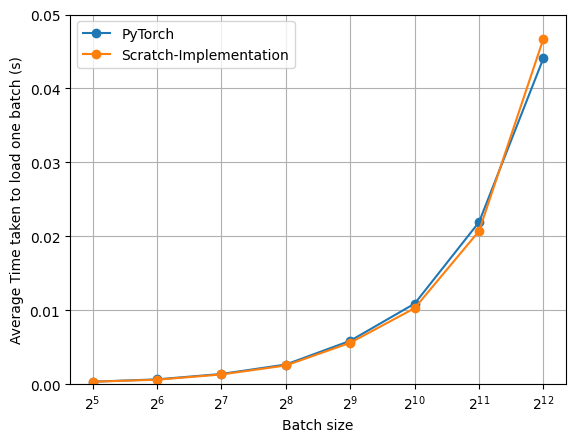

In [7]:
plt.plot([2**i for i in range(5, 13)], times[0], label="PyTorch", marker="o")
plt.plot([2**i for i in range(5, 13)], times[1], label="Scratch-Implementation", marker="o")

plt.xlabel("Batch size")
plt.ylabel("Average Time taken to load one batch (s)")
plt.legend()

plt.xscale("log", base=2)
plt.ylim(0, 0.05)
plt.grid(True)
plt.show()

## **Common Hyperparameters, Plotter, and Data for all models**

The following cell contains hyperparameters and loads the data, which is common for all the models. Since the MNIST Dataset is a relatively simple one, we try to minimize the number of learnable parameters in each linear layer to speed up learning and avoid overfitting. Not surprisingly, the model learns almost equally well with using $[32, 32, 32, 32]$ neurons in hidden layers as opposed to $[356, 128, 64, 32]$ or the likes.

We also define a plotter function to plot the results of the models. It can plot models having LOSSES and ACCURACIES as attributes.

In [8]:
def plot(model: "NeuralNetwork|CustomNeuralNetwork", save: bool = False) -> None:
    """
    Plots the accuracy and loss curves of the given model. The model must have
    LOSSES and ACCURACIES attributes.
    """
    plt.figure(figsize=(13, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS+1), model.LOSSES[0], label="Train")
    plt.plot(range(1, EPOCHS+1), model.LOSSES[1], label="Test")
    plt.plot(range(1, EPOCHS+1), model.LOSSES[2], label="Validation")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS+1), model.ACCURACIES[0], label="Train")
    plt.plot(range(1, EPOCHS+1), model.ACCURACIES[1], label="Test")
    plt.plot(range(1, EPOCHS+1), model.ACCURACIES[2], label="Validation")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    plt.yticks(torch.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(True)

    plt.show()


INPUT_SIZE: int = 28 * 28
HIDDEN_SIZE: list[int] = [32, 32, 32, 32]
OUTPUT_SIZE: int = 10
EPOCHS: int = 60
LR: float = 3e-4
BATCH_SIZE: int = 128

train_data = MNISTDataset(root="data", train=True, download=True, transform=ToTensor(scale=1.0))
test_data = MNISTDataset(root="data", train=False, download=True, transform=ToTensor(scale=1.0))

size = int(0.8 * len(train_data))
train_data, val_data = random_split(train_data, [size, len(train_data) - size])

TRAIN_LOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
TEST_LOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
VAL_LOADER = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

## **Question: 2**

In this question, we implement a simple Feed-Forward Neural Netowrk using Pytorch with the following specifications:
- 4 Hidden Layers
- At least 32 Nodes in each Hidden Layer
- Load the data using the more effective dataloader as identified in Question-1
- Activation Function: [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Loss Function: [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- Optimizer: [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
- Learning Rate: 0.0003

Finally, we plot graphs of the loss and accuracy vs number of epochs for training, testing, and validation data for 60 epochs.

### **Obeservations & Solutions**

The Neural Network, implemented in the class `NeuralNetwork(torch.nn.Module)`, is given in the following cells. The model is subject to the given constraints and is trained on the MNIST dataset. The training and testing data is loaded using the `torch` implementation of `DataLoader` as identified in Question-1. The model is trained for 60 epochs and the loss and accuracy are plotted for the training, testing, and validation data.

1. We note that due to the small learning rate, the gradients in the model are not significant, and hence the updates are extremely noisy. In fact, more often than not, the model gets stuck in local minimas and hovers around it.
2. Even with 4 hidden layers of 128 neurons each, the model achieves a menial accuracy of $0.12$ (when the input is normalized).
3. We realize that the model is able to learn with higher learning rates, further confirming our belief that we need artificial gradient magnification.
4. Since we are using the ReLU activation function, it is easy to realize that the output of the hidden layers will be (somewhat) *proportional* to the input. Hence, contrary to our intuition, we feed the data to the model without normalizing it. Since we are not allowed to change the model architecture, we artificially magnify the gradients by using non-normalized data.
5. The model is then able to learn effectively and consistently achieves $0.95+$ accuracy on the test and validation data.

### **References**

1. [PyTorch Crash Course - Getting Started with Deep Learning, YouTube](https://www.youtube.com/watch?v=OIenNRt2bjg)
2. [PyTorch Official Documentation](https://pytorch.org/docs/stable/index.html)

In [9]:
class NeuralNetwork(nn.Module):
    """
    Represents a generalized simple feedforward neural network.
    The number of hidden layers and the number of neurons in each hidden layer
    can be varied. The network automatically adds Batch Normalization layers
    to deeper networks and when using the Sigmoid activation function.
    :params:
        input_size: the number of neurons in the input layer
        hidden_size: a list containing the number of neurons in each hidden layer
        output_size: the number of neurons in the output layer
        activation: the activation function to be used in the hidden layers
    :attrs:
        layers: the layers of the neural network
        criterion: the loss function to be used
        optimizer: the optimization algorithm to be used
        ACCURACIES: a tensor to store the accuracies of the network per epoch
        LOSSES: a tensor to store the losses of the network per epoch
    """

    ACCURACIES: torch.Tensor
    LOSSES: torch.Tensor

    def __init__(self, input_size: int, hidden_size: list[int], output_size: int, activation: nn.Module):
        """
        Initializes the NeuralNetwork. See help(NeuralNetwork) for more information.
        """
        super(NeuralNetwork, self).__init__()
        batch_norm = activation == nn.Sigmoid or len(hidden_size) > 4
        layers = []
        layers.append(nn.Linear(input_size, hidden_size[0]))
        layers.append(activation())
        if batch_norm:
            layers.append(nn.BatchNorm1d(hidden_size[0], affine=False))
        for i in range(len(hidden_size)-1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            layers.append(activation())
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size[i+1], affine=False))
        layers.append(nn.Linear(hidden_size[-1], output_size))

        self.LOSSES = torch.zeros(3, 1)
        self.ACCURACIES = torch.zeros(3, 1)
        self.layers = nn.Sequential(*layers)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the output of the neural network (forward pass) for the given input.
        """
        return self.layers(x)

    def train(self, dataloader: list[CustomDataLoader|DataLoader], epochs: int, lr: float, verbose: bool|None = False) -> None:
        """
        Trains the neural network using dataloader[0] as the training set. The network
        is evaluated using every dataloader after every epoch.
        :params:
            dataloader: a list containing the training, testing and validation dataloaders
            epochs: the number of epochs to train the network
            lr: the learning rate of the optimization algorithm
            verbose: if True, the accuracies and losses of the network will be printed after every epoch
        """
        self.ACCURACIES.resize_(3, epochs)
        self.LOSSES.resize_(3, epochs)

        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            self.loop(dataloader[0], 0, epoch)
            with torch.no_grad():
                self.loop(dataloader[1], 1, epoch, evaluate=True)
                self.loop(dataloader[2], 2, epoch, evaluate=True)
            if verbose:
                epoch_ = f"Epoch [{str(epoch+1).zfill(2)}/{epochs}]"
                print(f"{epoch_}, Accuracy: {self.ACCURACIES[:, epoch]}, Loss: {self.LOSSES[:, epoch]}", end="\r")

    def loop(self, dataloader: CustomDataLoader|DataLoader, index: int, epoch: int, evaluate: bool = False) -> None:
        """
        Runs one epoch of training using the given dataloader if evaluate is False.
        If evaluate is True, the gradients are not calculated and the network is evaluated.
        :params:
            dataloader: the dataloader to be used
            index: the index of the dataloader
            epoch: the current epoch
            evaluate: if True, the network does not backpropagate
        """
        total_loss = correct = total = 0
        for images, labels in dataloader:
            outputs = self.forward(images.reshape(-1, 28*28))
            total_loss += (loss := self.criterion(outputs, labels)).item()
            correct += (outputs.argmax(axis=1) == labels).sum().item()
            total += labels.shape[0]
            if not evaluate:
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

        self.ACCURACIES[index, epoch] = correct / total
        self.LOSSES[index, epoch] = total_loss / total

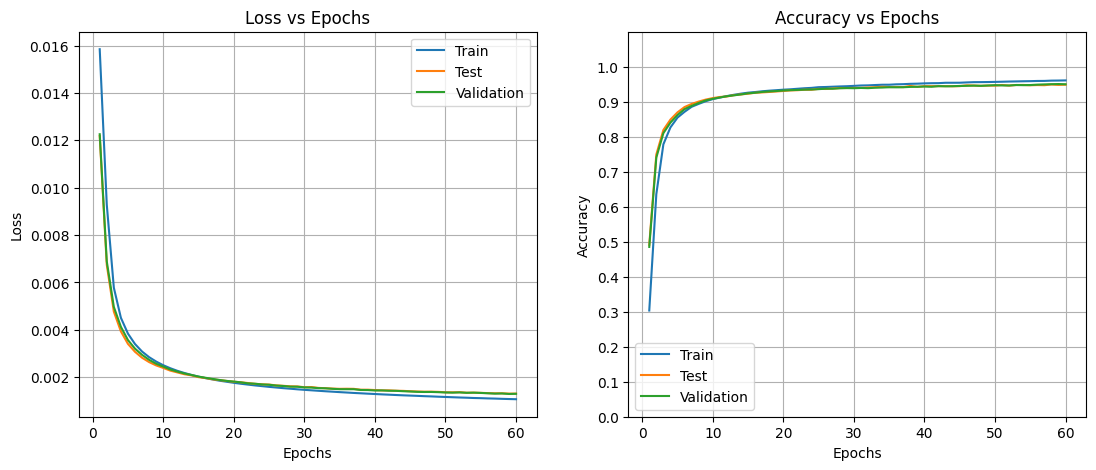

In [10]:
model = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, activation=nn.ReLU)
model.train([TRAIN_LOADER, TEST_LOADER, VAL_LOADER], EPOCHS, LR, verbose=True)
plot(model)

## **Question: 3**

In this question, we are required to write the same FeedForward network, this time, completely from scratch using only PyTorch Tensor operations, while manually implementing the trianing loop and gradient calculations. The same hyperparameters as in Question-2 are used. The model is trained for 60 epochs, and the loss and accuracy vs number of epochs for training, testing, and validation data are plotted.

### **Observations & Solutions**

Using the given template in `template.py`, we note that we are required to create the model, the loss function, the optimizer, and anything and everything we use, from scratch. We take a modular approach, by defining an abstract base class `Layer` to represent a layer in the neural network. We then define the layers `Linear(Layer)` and `ReLU(Layer)`, inherting from `Layer`. Finally, we implement the loss `CrossEntropyLoss` and `SGD` optimizer from scratch.

Each layer has its own `forward` and `backward` methods, implementing the forward and backward passes, respectively. The `forward` method is used to calculate the output of the layer, and the `backward` method is used to calculate the gradients of the layer during backpropagation using the chain rule. The `update` method of each layer updates the weights, if needed. The `CrossEntropyLoss` has been designed in a similar manner. The optimizer `SGD` is implemented to take and update the model parameters in every step.

Finally, we implement the FeedForward Neural Network using the layers in the class `CustomNeuralNetwork`. The model exactly mimics the `NeuralNetwork` model, with the only difference being - we implement each and every functionality from scratch. The model is trained for 60 epochs and the loss and accuracy are plotted for the training, testing, and validation data.

In [66]:
class Layer:
    """
    Abstract class to represent a Layer of a Neural Network. A CustomNeuralNetwork
    is a stack of Layers. Each layer must define a forward, backward, and
    update method.
    """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the output of the layer for the given input.
        :param x: the input to the layer
        """
        raise NotImplementedError

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of the loss with respect to the input of the layer.
        :param grad: the gradient of the loss with respect to the output of the layer
        """
        raise NotImplementedError

    def update(self, lr: float) -> None:
        """
        Updates the parameters of the layer using the given learning rate.
        :param lr: the learning rate of the optimization algorithm
        """
        raise NotImplementedError


class Linear(Layer):
    """
    Represents a (fully-connected) Linear Layer of a Neural Network. The layer
    is defined by a weight matrix and a bias vector. Of course, technically,
    the layer performs an affine transformation. Weights of the layer are
    initialized using Xavier's Method.
    :params:
        input_size: the number of neurons in the input layer
        output_size: the number of neurons in the output layer
    :attrs:
        weight: the weight matrix of the layer
        bias: the bias vector of the layer
        x: the input to the layer
        weight_grad: the gradient of the loss with respect to the weight matrix
        bias_grad: the gradient of the loss with respect to the bias vector
    """

    def __init__(self, input_size: int, output_size: int):
        """
        Initializes the Linear Layer. See help(Linear) for more information.
        """
        self.input_size = input_size
        self.output_size = output_size
        scale = 1 / self.input_size**0.5
        self.weight = torch.rand(input_size, output_size) * 2*scale - scale
        self.bias = torch.rand(output_size) * 2*scale - scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.x = x
            return self.x @ self.weight + self.bias

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.weight_grad = self.x.T @ grad
            self.bias_grad = grad.sum(axis=0)
            return grad @ self.weight.T

    def update(self, lr: float) -> None:
        with torch.no_grad():
            self.weight -= lr * self.weight_grad
            self.bias -= lr * self.bias_grad


class ReLU(Layer):
    """
    Represents a ReLU Layer of a Neural Network. The layer applies the ReLU
    activation function to the input. It does not have any parameters.
    :attrs:
        x: the input to the layer
    """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.x = x
            return torch.max(x, torch.zeros_like(x))

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return grad * (self.x >= 0).float()

    def update(self, lr: float) -> None:
        pass


class Sigmoid(Layer):
    """
    Represents a Sigmoid Layer of a Neural Network. The layer applies the Sigmoid
    activation function to the input. It does not have any parameters.
    :attrs:
        sigmoid: the output of the layer
    """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.sigmoid = 1 / (1 + torch.exp(-x))
            return self.sigmoid

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return grad * self.sigmoid * (1 - self.sigmoid)

    def update(self, lr: float) -> None:
        pass


class CrossEntropyLoss:
    """
    Represents the Cross Entropy Loss function. The loss function is used to
    measure the error in the output of a Neural Network. Loss can be
    calculated by calling the loss object. The loss function expects the
    output to be raw (non-normalized).
    """

    def __call__(self, outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Returns the loss of the network for the given outputs and targets.
        :param outputs: the output of the network
        :param targets: the target of the network
        """
        with torch.no_grad():
            exp = torch.exp(outputs)
            self.outputs = torch.clamp(exp/exp.sum(axis=1, keepdim=True), 1e-12, 1 - 1e-12)
            self.targets = targets
            return -torch.log(self.outputs[range(len(targets)), targets]).mean()

    def backward(self) -> torch.Tensor:
        """
        Returns the gradient of the loss with respect to the output of the network.
        This is the step where backpropagation begins.
        """
        with torch.no_grad():
            return self.outputs - torch.eye(self.outputs.shape[1])[self.targets]


class SGD:
    """
    Represents the Stochastic Gradient Descent optimization algorithm. The
    algorithm is used to update the parameters of a Neural Network.
    :params:
        parameters: the parameters of the network
        lr: the learning rate of the algorithm
    """

    def __init__(self, parameters: list[Layer], lr: float):
        """
        Initializes the SGD optimizer. See help(SGD) for more information.
        """
        self.parameters = parameters
        self.lr = lr

    def step(self, grad: torch.Tensor) -> None:
        """
        Updates the parameters of the network using backpropagation beginning
        with the given gradient of the loss.
        :param grad: the gradient of the loss with respect to the output of the network
        """
        with torch.no_grad():
            for i in range(len(self.parameters)-1, -1, -1):
                grad = self.parameters[i].backward(grad)
                self.parameters[i].update(self.lr)


class CustomNeuralNetwork:
    """
    An exact replica of class NeuralNetwork but implemented from scratch.
    All layers of the network, the loss, the gradients, and the optimization
    algorithm are implemented from scratch.
    All computations are done using PyTorch Tensors in the no_grad context
    to avoid computational overhead and ensure that the network is trained
    using manually implemented gradients.
    See help(NeuralNetwork) for more information on the parameters and attributes.
    """

    ACCURACIES: torch.Tensor
    LOSSES: torch.Tensor

    def __init__(self, input_size: int, hidden_size: list[int], output_size: int, activation: Layer):
        """
        Initializes the CustomNeuralNetwork. See help(CustomNeuralNetwork) for more information.
        """
        self.layers = []
        self.layers.append(Linear(input_size, hidden_size[0]))
        self.layers.append(activation())
        if activation == Sigmoid:
            self.layers.append(BatchNorm(hidden_size[0], affine=False))
        for i in range(len(hidden_size)-1):
            self.layers.append(Linear(hidden_size[i], hidden_size[i+1]))
            self.layers.append(activation())
            if activation == Sigmoid:
                self.layers.append(BatchNorm(hidden_size[i+1], affine=False))
        self.layers.append(Linear(hidden_size[-1], output_size))

        self.LOSSES = torch.zeros(3, 1)
        self.ACCURACIES = torch.zeros(3, 1)
        self.criterion = CrossEntropyLoss()

    def parameters(self) -> list[Layer]:
        """
        Returns the parameters of the network.
        """
        return self.layers

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the output of the network for the given input.
        """
        with torch.no_grad():
            for layer in self.layers:
                x = layer.forward(x)
        return x

    def train(self, dataloader: list[CustomDataLoader|DataLoader], epochs: int, lr: float, verbose: bool|None = False) -> None:
        """
        Trains the network using dataloader[0] as the training set. The network
        is evaluated using every dataloader after every epoch.
        :params:
            dataloader: a list containing the training, testing and validation dataloaders
            epochs: the number of epochs to train the network
            lr: the learning rate of the optimization algorithm
            verbose: if True, the accuracies and losses of the network will be printed after every epoch
        """
        self.ACCURACIES.resize_(3, epochs)
        self.LOSSES.resize_(3, epochs)

        self.optimizer = SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            with torch.no_grad():
                self.loop(dataloader[0], 0, epoch)
                self.loop(dataloader[1], 1, epoch, evaluate=True)
                self.loop(dataloader[2], 2, epoch, evaluate=True)
            if verbose:
                epoch_ = f"Epoch [{str(epoch+1).zfill(2)}/{epochs}]"
                print(f"{epoch_}, Accuracy: {self.ACCURACIES[:, epoch]}, Loss: {self.LOSSES[:, epoch]}", end="\r")

    def loop(self, dataloader: CustomDataLoader|DataLoader, index: int, epoch: int, evaluate: bool = False) -> None:
        """
        Runs one epoch of training using the given dataloader if evaluate is False.
        If evaluate is True, the gradients are not calculated and the network is evaluated.
        :params:
            dataloader: the dataloader to be used
            index: the index of the dataloader
            epoch: the current epoch
            evaluate: if True, the network does not backpropagate
        """
        total_loss = correct = total = 0
        for images, labels in dataloader:
            outputs = self.forward(images.reshape(-1, 28*28))
            total_loss += (loss := self.criterion(outputs, labels)).item()
            correct += (outputs.argmax(axis=1) == labels).sum().item()
            total += labels.shape[0]
            if not evaluate:
                self.optimizer.step(self.criterion.backward())

        self.ACCURACIES[index, epoch] = correct / total
        self.LOSSES[index, epoch] = total_loss / total

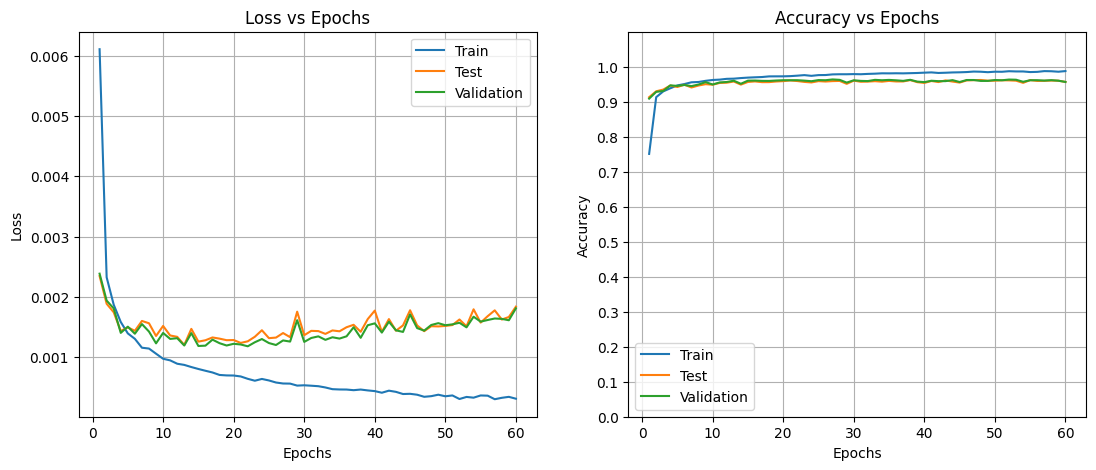

In [12]:
model = CustomNeuralNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, activation=ReLU)
model.train([TRAIN_LOADER, TEST_LOADER, VAL_LOADER], EPOCHS, LR, verbose=True)
plot(model)

## **Question: 4**

In this question, we repreat both Question-2 and Question-3, but just using `torch.nn.Sigmoid` as the activation function instead of `torch.nn.ReLU`. The same hyperparameters as in Question-2 are used. The model is trained for 60 epochs, and the loss and accuracy vs number of epochs for training, testing, and validation data are plotted.

### **Observations & Solutions**

Due to the modular implementation of the models, we can reuse the above code to implement the models with the Sigmoid activation function. The `torch.nn.Sigmoid` layer is used in the (PyTorch) `NeuralNetwork` model, and the `Sigmoid(Layer)` (implemented above) layer is used in the `CustomNeuralNetwork` model. The models are trained for 60 epochs and the loss and accuracy are plotted for the training, testing, and validation data.

1. Here, we again face the vanishing gradient problem, and the model is not able to learn effectively. In fact, sometimes, the gradients achieve a zero-value, making backpropagation impossible.
2. We realize that the Sigmoid activation function is not suitable for deep networks in general, unless we can artificially magnify the gradients, which cannot be done through scaling the input data, since the sigmoid function takes input in the range $[-\infty, \infty]$ and spits out a number in the range $[0, 1]$.
3. The model is not able to learn effectively and consistently achieves $\leq 0.2$ accuracy on the test and validation data.
4. To help stabilize learning and avoid the vanishing gradient problem, we make use of the Batch Normalization technique. This layer scales and standardizes the output of each layer, making the gradients more significant. The `torch.nn.BatchNorm1d` layer is used in the (PyTorch) `NeuralNetwork` model, and the `BatchNorm(Layer)` layer is used in the `CustomNeuralNetwork` model. Note, that we do not add any learnable parameters to the `BatchNorm` layer, and only use it to standardize the output of the previous layer (so that the gradients are also scaled during backpropagation).
5. The model is then able to learn effectively and consistently achieves $0.90+$ accuracy on the test and validation data.

However, compared the the ReLU activation function, the Sigmoid function performs slightly worse. This is probably because the Sigmoid function is not suitable for deep networks in general.

### **References**

1. [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
2. [Batch Normalization (PyTorch) Officail Documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
3. [Lecture Slides: Batch Normalization](https://drive.google.com/file/d/1g726uRBYtVRqe46-Tg8mK4d4TxGh1qI-/view)

In [13]:
class BatchNorm(Layer):
    """
    Represents a 1-dimensional Batch Normalization Layer of a Neural Network.
    The layer normalizes the input and scales and shifts the normalized input using
    a learned affine transformation. The layer has learnable parameters.
    :params:
        input_size: the number of neurons in the input layer
        affine: if True, the layer will learn an affine transformation
    :attrs:
        scale: the scale parameter of the layer
        shift: the shift parameter of the layer
    """

    def __init__(self, input_size: int, affine: bool = True):
        """
        Initializes the BatchNorm Layer. See help(BatchNorm) for more information.
        """
        self.input_size = input_size
        self.affine = affine
        if self.affine:
            scale = 1 / self.input_size**0.5
            self.scale = torch.rand(input_size) * 2*scale - scale
            self.shift = torch.rand(input_size) * 2*scale - scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.x = x
            self.mean = x.mean(axis=0)
            self.std = torch.clamp(x.std(axis=0), 1e-12, 1e+12)
            self.centered = x - self.mean
            return self.centered / self.std

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.mean_grad = grad.mean(axis=0)
            self.std_grad = (grad * self.centered).mean(axis=0) / self.std
            if self.affine:
                self.scale_grad = (grad * self.x).mean(axis=0) / self.std
                self.shift_grad = grad.mean(axis=0)
                return grad * self.scale / self.std - 1/self.input_size * (self.scale_grad + self.std_grad * self.centered.mean(axis=0) / self.std**2)
            return grad/self.std - 1/self.input_size * (self.mean_grad + self.std_grad * self.centered.mean(axis=0) / self.std**2)

    def update(self, lr: float) -> None:
        with torch.no_grad():
            if self.affine:
                self.scale -= lr * self.scale_grad
                self.shift -= lr * self.shift_grad

### **PyTorch Model**

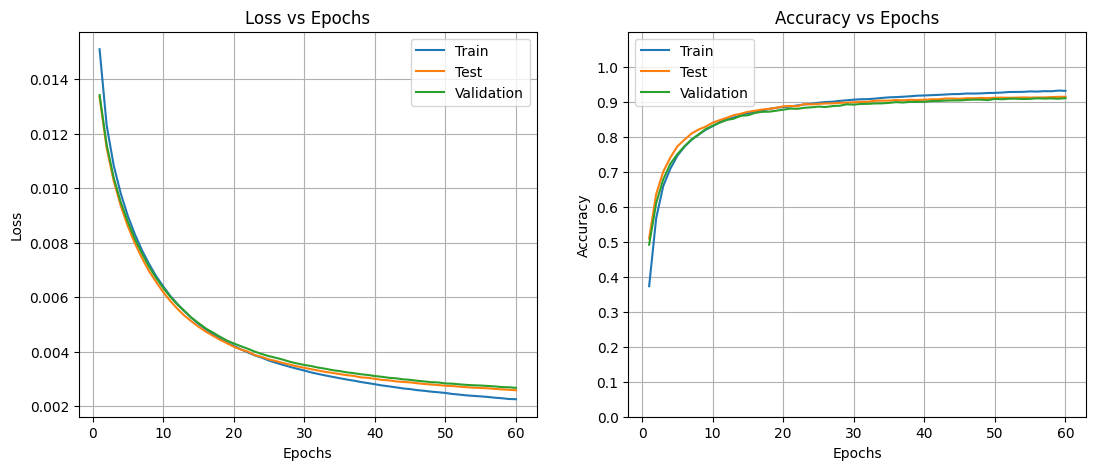

In [14]:
model = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, activation=nn.Sigmoid)
model.train([TRAIN_LOADER, TEST_LOADER, VAL_LOADER], EPOCHS, LR, verbose=True)
plot(model)

### **Scratch Model**

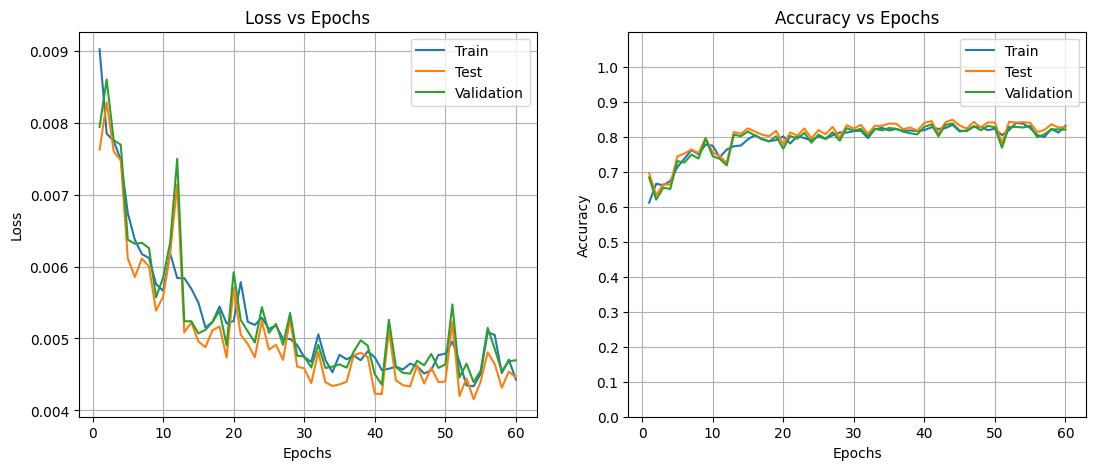

In [15]:
model = CustomNeuralNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, activation=Sigmoid)
model.train([TRAIN_LOADER, TEST_LOADER, VAL_LOADER], EPOCHS, LR, verbose=True)
plot(model)

## **Bonus Question: 1**

In this question, we implement a Neural Netowrk architecture with the same parameters as in the above settings, but we try to maximize the number of hidden layers while ensruing that each layer of the network consists of at least 400 neurons. The model is trained for 60 epochs, and the loss and accuracy vs number of epochs for training, testing, and validation data are plotted.

### **Observations**

Increasing the number of hidden layers, we realize that the learning becomes much slower. This is probably because the final output is dependent on more number of parameters, and hence more updates are required to get every parameter to a "good" value. However, the model is consistent and effective - given a few more epochs, it can start achieving higher and higher accuracies. We also note that as the number of hidden layers increase, the time taken to run one epoch goes up significantly.

The following models feature 50 and 55 hidden layers of 400 neurons each. The models are trained for 60 epochs and the loss and accuracy are plotted for the training, testing, and validation data. As we have seen, though, even a $32 \times 4$ hidden layer architecture is able to learn effectively.

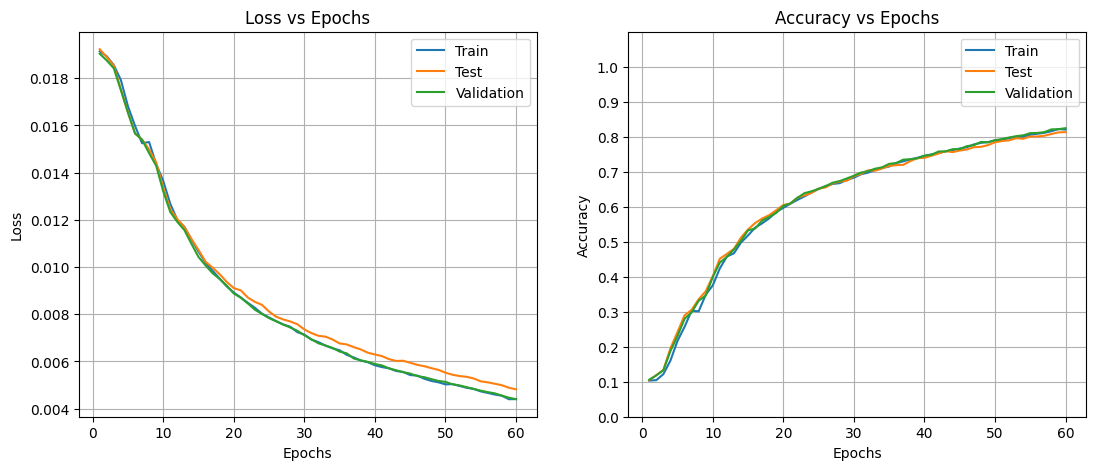

In [25]:
model = NeuralNetwork(INPUT_SIZE, [400]*50, OUTPUT_SIZE, activation=nn.ReLU)
model.train([TRAIN_LOADER, TEST_LOADER, VAL_LOADER], EPOCHS, LR, verbose=True)
plot(model)

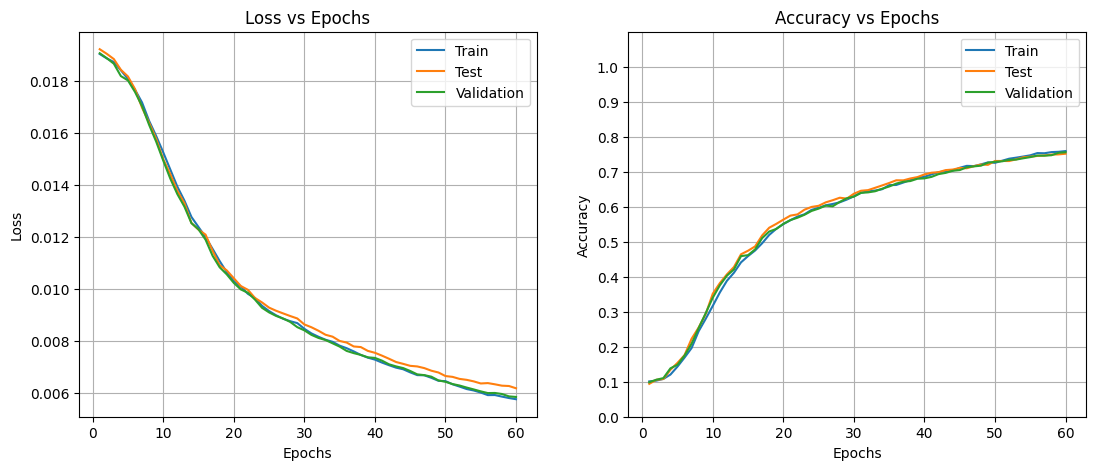

In [56]:
model = NeuralNetwork(INPUT_SIZE, [400]*55, OUTPUT_SIZE, activation=nn.ReLU)
model.train([TRAIN_LOADER, TEST_LOADER, VAL_LOADER], EPOCHS, LR, verbose=True)
plot(model)

## **Bonus Question: 2**

In this question, we implement a Neural Netowrk architecture with the same parameters as in the above settings, but we try to minimize the training time taken for 60 epochs. I have implemented many small optimizations, hoping to reduce the training time.

In [63]:
REPEATS: int = 5
total_time = 0

for repeat in range(1, REPEATS+1):
    print(f"Repeat: {repeat} of {REPEATS}")
    start = time.time()
    model = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, activation=nn.ReLU)
    model.train([TRAIN_LOADER, TEST_LOADER, VAL_LOADER], EPOCHS, LR, verbose=False)
    print()
    total_time += time.time() - start

print(f"Average Time taken to train: {total_time/REPEATS/60:.5f} minutes")

Average Time taken to train: 5.71368 minutes
